In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, Plots, PhasorNetworks

In [3]:
using Lux, NNlib, Zygote, ComponentArrays, Optimisers

In [4]:
using Random: Xoshiro

In [5]:
phases = -1.0:0.1:1.0 |> collect
n_in = length(phases)

21

In [6]:
sa = SpikingArgs()
train = phase_to_train(phases, spk_args=sa, repeats=1)

Spike Train: (21,) with 21 spikes.

In [9]:
using PhasorNetworks: gaussian_kernel

In [10]:
function cfn(train::SpikeTrain, t::Real, spk_args::SpikingArgs; sigma::Real = 9.0)

    #add currents into the active synapses
    current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
    impulses = current_kernel(train.times)

    return impulses
end

cfn (generic function with 1 method)

In [11]:
cfn(train, 0.5, sa)

21-element Vector{Float64}:
 3.6808558548018004e-272
 1.3753667993264065e-220
 1.9151695967140057e-174
 9.938364413483684e-134
 1.921947727823849e-98
 1.3851193699226017e-68
 3.720075976020836e-44
 3.7233631217504573e-25
 1.388794386496412e-11
 0.0019304541362277128
 1.0
 0.001930454136227687
 1.388794386496412e-11
 3.7233631217504573e-25
 3.7200759760209417e-44
 1.3851193699226017e-68
 1.92194772782374e-98
 9.938364413483684e-134
 1.9151695967140057e-174
 1.375366799326641e-220
 3.6808558548018004e-272

In [12]:
current_fn = t -> cfn(train, t, sa)

#7 (generic function with 1 method)

In [13]:
current_sample = stack(current_fn.(0.0:0.001:1.0), dims=1);

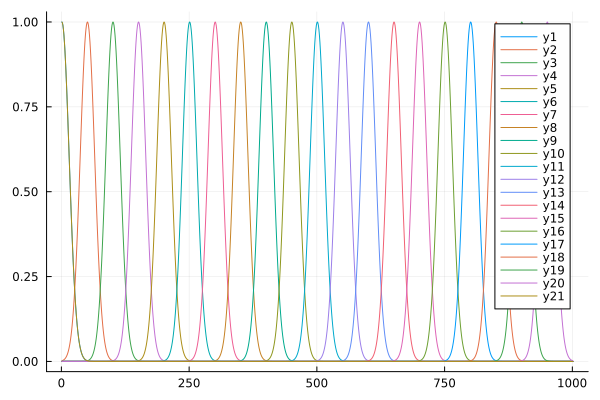

In [14]:
plot(current_sample)

In [15]:
ode_fn = Chain(Dense(n_in => 10))

Dense(21 => 10)     # 220 parameters

In [20]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [21]:
in_ps, in_st = Lux.setup(rng, ode_fn)

((weight = Float32[-0.0400497 0.02070695 … -0.3404514 0.19705269; -0.2872161 -0.014938566 … 0.10949896 0.3847625; … ; -0.4100781 -0.15121788 … -0.0032900907 -0.1967657; 0.023770005 -0.3568528 … -0.40741447 0.19531876], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), NamedTuple())

In [22]:
smp = current_fn(0.0);

In [23]:
size(smp)

(21,)

In [24]:
smp1, _ = ode_fn(smp, in_ps, in_st)

([0.1570429630206906, 0.09751756042389026, -0.2302793769117927, 0.04737621238874912, 0.5044325736032231, -0.6091836290102796, -0.3833970355123464, -0.11673867348487127, -0.6071357334287122, 0.218399875033601], NamedTuple())

In [25]:
zeros(Complex, size(smp1))

10-element Vector{Complex}:
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im
 0 + 0im

In [26]:
smp1 |> size

(10,)

In [27]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),)

PhasorODE(
    model = Dense(21 => 10),            # 220 parameters
)         # Total: 220 parameters,
          #        plus 0 states.

In [28]:
ps, st = Lux.setup(rng, ode_model)

((weight = Float32[0.15775202 -0.30030665 … -0.11187771 0.27858263; 0.20926023 0.2248124 … -0.3451473 -0.115503974; … ; -0.25044537 0.09787141 … 0.42805064 -0.2150186; -0.42859238 0.36548153 … -0.1841149 0.17529532], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), NamedTuple())

In [29]:
out1, st1 = ode_model(current_fn, ps, st)

(ODESolution{ComplexF32, 2, Vector{Vector{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF32}}}, ODEProblem{Vector{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#127"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#7#8", @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof

In [30]:
u1 = Array(out1)

10×1 Matrix{ComplexF32}:
  0.027360586f0 + 0.020868445f0im
   0.03612447f0 - 0.004105597f0im
 0.0014465499f0 - 0.00013432252f0im
  0.022712786f0 + 0.031964026f0im
 -0.022251867f0 - 0.0049148416f0im
  0.014011123f0 - 0.004228383f0im
 -0.024612464f0 + 0.025028579f0im
 -0.017094236f0 - 0.076795906f0im
  0.032509144f0 + 0.009761772f0im
 -0.015488641f0 - 0.019387562f0im

In [31]:
y1 = complex_to_angle(u1)

10×1 Matrix{Float32}:
  0.20740812
 -0.0360218
 -0.029472835
  0.30335227
 -0.9308048
 -0.09329534
  0.7473318
 -0.56971693
  0.09285467
 -0.71456224

In [32]:
#calc a gradient through a loss fn on the network

In [36]:
function test_loss(model, ps, st)
    sol, _ = model(current_fn, ps, st)
    p0 = complex_to_angle(Array(sol))
    err = abs(sum(p0))
    return err
end

test_loss (generic function with 1 method)

In [37]:
test_loss(ode_model, ps, st)

1.022927f0

In [38]:
psa = ComponentArray(ps)

ComponentVector{Float32}(weight = Float32[0.15775202 -0.30030665 … -0.11187771 0.27858263; 0.20926023 0.2248124 … -0.3451473 -0.115503974; … ; -0.25044537 0.09787141 … 0.42805064 -0.2150186; -0.42859238 0.36548153 … -0.1841149 0.17529532], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])

In [39]:
grads = gradient(p -> test_loss(ode_model, p, st), psa)

((weight = Float32[0.08884447 0.22216173 … 0.10709332 0.08884447; -0.0053646234 0.051107682 … -0.12676847 -0.0053646234; … ; 0.0483199 0.15597965 … -0.007296933 0.0483199; -0.1534323 -0.35053158 … -0.24673025 -0.1534323], bias = Float32[-0.20683321; -0.25162166; … ; -0.25638086; 0.22155844;;]),)

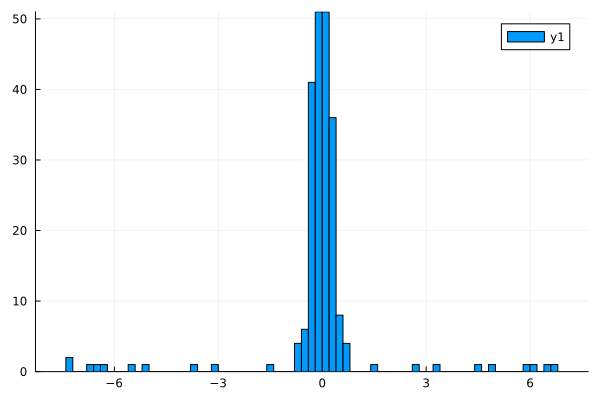

In [40]:
histogram(grads[1])

In [41]:
opt_state = Optimisers.setup(Adam(3e-4), psa)

Leaf(Adam(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))

In [42]:
losses = []

Any[]

In [47]:
for i in 1:100
    lossval, gs = withgradient(p -> test_loss(ode_model, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

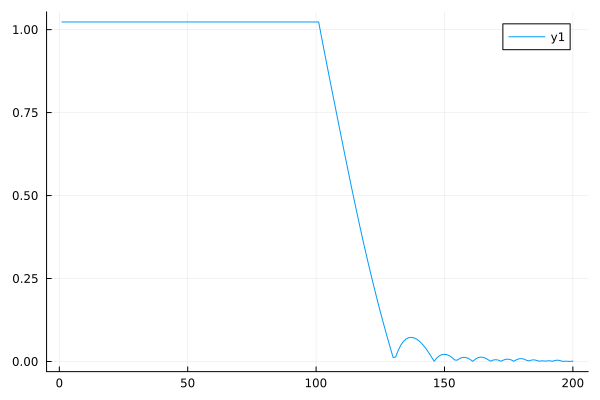

In [48]:
plot(losses)